In [44]:
# -*- coding: <encoding name> -*-
"""Create parameters.py and load it"""
# Directory for .inp file:
#path = 'INP file examples//chemkin_AR_HE_1_reac.inp'
#path = 'INP fil examples//notused_reactions_commented_chemkin_AR_HE.inp'
#path = 'INP file examples//chem_Otomo2018.inp'
#path = 'INP file examples//chem_Otomo2018_FIXED_by_Cantera.inp'
#path = 'INP file examples//chem_Otomo2018_without_O_reactions_FIXED_by_Cantera.inp'
path = 'INP file examples//chem_KAUST2023_N2_carbonfree_without_O_FIXED_by_Cantera.inp'
#path = 'INP file examples//chem_Otomo2018_without_O_just_not_pressure_dependent.inp'
#path = 'INP file examples//chem_Otomo2018_one_Lindemann_reaction.inp'
#path = 'INP file examples//chem_Otomo2018_one_Troe_reaction.inp'
#path = 'INP file examples//chem_Otomo2018_one_PLOG_reaction.inp'
#path = 'INP file examples//chem_Otomo2018_without_O_one_not_pressure_dependent_reaction.inp'
#path = 'INP file examples//chem_Otomo2018_without_O_one_fictive_normal_reaction.inp'
#path = 'INP file examples//chemkin_AR_HE.inp'
#path = 'INP file examples//chemkin_USON2022.inp'
#path = 'INP file examples//chem_Otomo2018_1reak.inp'
#path = 'INP file examples//chem_Otomo2018_FIXED_by_Cantera.inp'
#path = 'INP file examples//chem_KAUST2023_N2_carbonfree_FIXED_by_Cantera.inp'
#path = 'INP file examples//chem_KAUST2023_N2_carbonfree.inp'

# import libraries:
import importlib   # For reloading your own files
import numpy as np
# my own files:
import inp_data_extractor as inp   # numeric constants and coefficents
importlib.reload(inp)   # reload changes you made
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

path=INP file examples//chem_KAUST2023_N2_carbonfree_without_O_FIXED_by_Cantera.inp
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NN' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H2' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H3' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H4' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Warning, third body 'H2O' is not in species in line 72 ('H2/2.5000/ H2O/12.0000/ AR/0.0000/ HE/0.0000/ ') in reaction 'H2+M=2H+M'
Warning, third body 'H2O' is not in species in line 87 ('H2O/7.0000/ ') in reaction 'N2H2+M=NNH+H+M'
Warning, third body 'O2' is not in species in line 96 ('AR/0.5900/ N2/1.0000/ O2/0.

In [45]:
"""Import simulation"""
import numpy as np
import importlib
import full_bubble_model as de
from termcolor import colored
print(colored('A régi modell van használva!','red'))
importlib.reload(de)

A régi modell van használva!
model: chem_KAUST2023_N2_carbonfree_without_O_FIXED_by_Cantera
target specie: NH3
excitation: sin_impulse (control parameters: ['p_A', 'freq', 'n'])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: True	enable reaction rate threshold: True	enable_time_evaluation_limit: False


C:\Users\fkubicsek\Downloads\Bubble_dynamics_simulation-mrkf100-patch-7-dimensionless-R-T-logconc\full_bubble_model.py:1202: SyntaxWarning: invalid escape sequence '\m'
  if cpar.ratio != 1.0:


<module 'full_bubble_model' from 'C:\\Users\\fkubicsek\\Downloads\\Bubble_dynamics_simulation-mrkf100-patch-7-dimensionless-R-T-logconc\\full_bubble_model.py'>

In [46]:
"""Control parameters"""
cpar = de.dotdict(dict(
    ID=0,
    R_E=4.6202319100429886e-05,#42e-6, # [m] 
    ratio=1.0, # [-]
    P_standard=101325.0, # [Pa]
    P_amb=100000.0*10.0,#2.2e2, #101325.0*2.0, # [Pa]
    alfa_M=0.35, # [-]
    Gamma=1.0, #[-]
    sigma_evap=0.4, #[-] 
    C_4_starred=-2.1412, #[-]
    T_inf=293.15, # [K]  #293.15,kuka
    surfactant=1.0, # [-]
    gases=[par.index['H2'], par.index['N2']], # indexes of species in initial bubble
    fractions=[0.75 ,0.25], # molar fractions of species in initial bubble
    P_v = 2338.339978450019,#2338.1, # [Pa]
    mu_L = 0.001, # [Pa*s]
    rho_L= 998.2, # [kg/m^3]
    c_L=1483.0,                            # [m/s]
    
    p_A=-1136144.5783132531,
    freq=10000.0,
     
    freq1=1.0e4,                          # [Hz]
    freq_ratio=2.0,#          freq2/freq1 # [-]
    p_A1=-2.0e5,                            # [Pa]
    n=1.0,
    p_A2=-0.8e5,                            # [Pa] 
    
    thermodynamicalcase = 2, #0='NonIsothermal-ConstantVolume', 1='Isothermal-ConstantVolume', 2='KellerMiksis
    shift_const=1.0e-20
))
cpar.theta_phase=3.0*np.pi/2.0*(1.0-cpar.freq_ratio) # [rad] in order to get the maxima of the two sinusoids at the same time

succecfully solved with LSODA solver


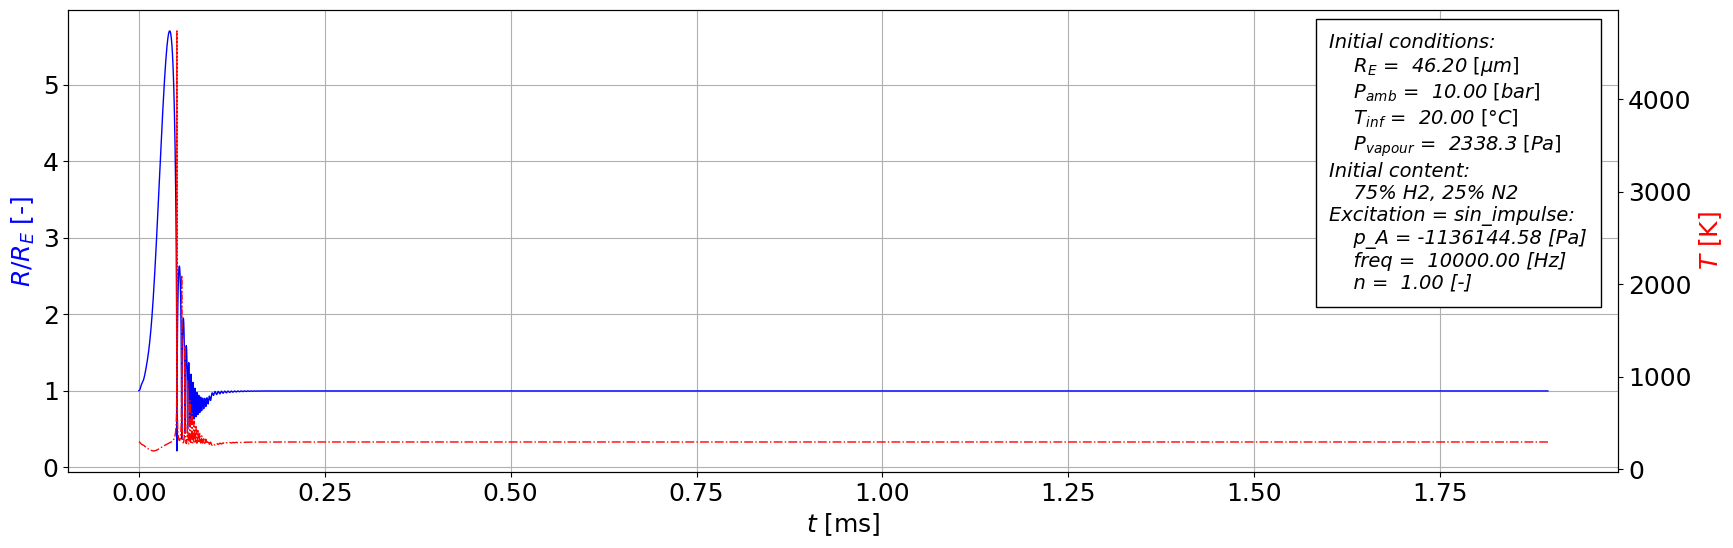

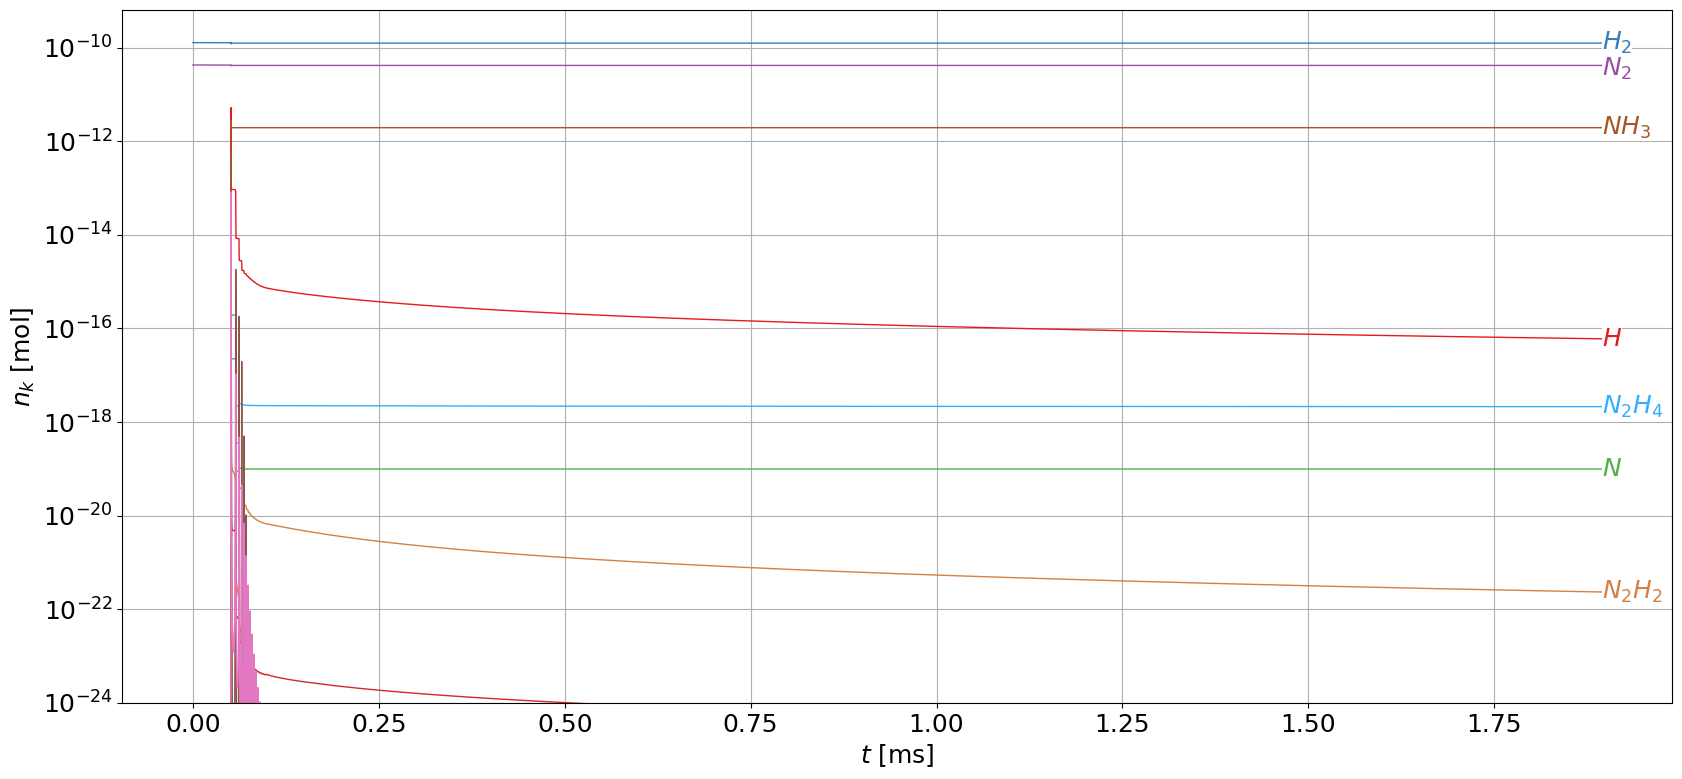

Control parameters:
    ID = 0,                                      # ID of control parameter (not used during calculation)
  # Initial conditions:
    R_E =  4.620232e-05,                         # bubble equilibrium radius [m]
    ratio =  1.00,                               # initial radius / equilibrium radius R_0/R_E [-]
    gases = [par.index['H2'], par.index['N2']],  # indexes of species in initial bubble (list of species indexes)
    fractions = [0.75, 0.25],                    # molar fractions of species in initial bubble (list of fractions for every gas)
  # Ambient parameters:
    P_amb =  1000000.00,                         # ambient pressure [Pa]
    T_inf =  293.15,                             # ambient temperature [K]
  # Liquid parameters:
    alfa_M =  0.3500,                            # water accommodation coefficient [-]
    P_v =  2338.34,                              # vapour pressure [Pa]
    mu_L =  0.001000,                            # dynamic viscosity [Pa*

In [47]:
"""Plotting"""
import numpy as np

# The event must specify whether it should terminate and whether to search for the roots
de.stop_event.terminal = True
de.stop_event.direction = 0  # Search for zero-crossing in both directions (up or down)

de.plot(cpar, t_int=np.array([0.0, 1.0e0]))

In [48]:
"""Saving"""
import numpy as np
file = de.Make_dir('test', separator=',')   # it makes a folder named 'test' in which it will save data

# The event must specify whether it should terminate and whether to search for the roots
de.stop_event.terminal = True
de.stop_event.direction = 0  # Search for zero-crossing in both directions (up or down)

num_sol, error_code, elapsed_time = de.solve(cpar, t_int=np.array([0.0, 1.0e0]))   # simulation without plotting
data = de.get_data(cpar, num_sol, error_code, elapsed_time)   # post processing
file.write_solution(data, num_sol, 'testfile')   # saving (it overwrites data)

# If you would like to save data in an other format you should modify the list_to_string method in fubll_bubble_model.py, class Make_dir.
# If you would like to save data in other order you should modify the write_solution method. 


Folder already exists with 2 csv in it


In [6]:
t_int=dict(t_int=np.array([0.0, 1.0e4])), 
n=5.0, 
base_name='', 
format='png', 
LSODA_timeout=30.0, 
Radau_timeout=300.0,
presentation_mode=False, 
plot_pressure=False, 
plot_extra=False, 
show_legend=False, 
show_cpar=True
if plot_extra:
    extra_dims = 4
else:
    extra_dims = 0
extra_dim_labels = ['Dissipated energy thermal term [J]', 'Dissipated energy viscous term [J]', 'Dissipated energy acoustic term [J]', 'Total dissipated energy [J]']
# Solve
if type(cpar) == dict:
    cpar = dotdict(cpar)
compression = 1 if base_name == '' else 0
num_sol, error_code, elapsed_time = de.solve(cpar, t_int, LSODA_timeout, Radau_timeout, extra_dims, print_errors=True)#, compression=compression)
data = de.get_data(cpar, num_sol, error_code, elapsed_time)

C:\Users\fkubicsek\Downloads\Bubble_dynamics_simulation-mrkf100-patch-7-dimensionless-R-T-logconc\full_bubble_model.py:1201: SyntaxWarning: invalid escape sequence '\m'
  text += f'    $R_E$ = {1e6*cpar.R_E: .2f} $[\mu m]$\n'


IndexError: tuple index out of range

In [ ]:
#Checking the excitation function:
excitation_type = 'double_sin_impulse_with_phase_shift'
Excitation, excitation_args, excitation_units, excitation_defaults = de.excitation.getExcitation(excitation_type=excitation_type)
ex_args = []
for key in excitation_args:
    ex_args.append(cpar.get(key, 0.0))
ex_args = np.array(ex_args, dtype=np.float64)
t=np.linspace(0,cpar.n/cpar.freq1,num=1000)
P=np.zeros(1000,dtype=np.float64)
for i in range(1000):
    (P[i], p_Inf_dot) = de.Excitation(t[i], cpar.P_amb, ex_args)
    
linewidth = 2.0 if presentation_mode else 1.0
import matplotlib.pyplot as plt   # for plotting
plt.rcParams.update({'font.size': 24 if presentation_mode else 18})
fig1 = plt.figure(figsize=(16, 9) if presentation_mode else (20, 6))
ax1 = fig1.add_subplot(axisbelow=True)
ax2 = ax1.twinx() 
ax1.plot(t, P, color = 'b', linewidth = linewidth)
#ax2.plot(t, T, color = 'r', linewidth = linewidth, linestyle = '-.')
if num_sol.t[-1] < 1e-3:
    ax1.set_xlabel('$t$ [μs]')
else:
    ax1.set_xlabel('$t$ [ms]')
ax1.set_ylabel('$P_\infty$ [Pa]', color = 'b')